In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [3]:
# Path of the file to read
train_file_path = '../input/house-prices-advanced-regression-techniques/train.csv'

train_df = pd.read_csv(train_file_path)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_file_path = '../input/house-prices-advanced-regression-techniques/test.csv'

test_df = pd.read_csv(test_file_path)
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
from sklearn.model_selection import train_test_split
X = train_df.copy()
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)



In [6]:
train_df.shape

(1460, 81)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
object_cols = [col for col in X.columns if X[col].dtype == "object"]
numerical_cols = [col for col in X.columns if X[col].dtype != "object"]
int_cols = [col for col in X.columns if X[col].dtype == "int64"]
float_cols = [col for col in X.columns if X[col].dtype == "float64"]

# 1. 處理Missing value

In [9]:
# 處理Missing value
features_with_nan=[features for features in train_df.columns if train_df[features].isnull().sum()>1]

for feature in features_with_nan:
    print(feature, np.round(train_df[feature].isnull().mean(),4), '%missing values')

LotFrontage 0.1774 %missing values
Alley 0.9377 %missing values
MasVnrType 0.0055 %missing values
MasVnrArea 0.0055 %missing values
BsmtQual 0.0253 %missing values
BsmtCond 0.0253 %missing values
BsmtExposure 0.026 %missing values
BsmtFinType1 0.0253 %missing values
BsmtFinType2 0.026 %missing values
FireplaceQu 0.4726 %missing values
GarageType 0.0555 %missing values
GarageYrBlt 0.0555 %missing values
GarageFinish 0.0555 %missing values
GarageQual 0.0555 %missing values
GarageCond 0.0555 %missing values
PoolQC 0.9952 %missing values
Fence 0.8075 %missing values
MiscFeature 0.963 %missing values


In [10]:
missing_train_df = pd.DataFrame(train_df.isna().sum(axis=0))
missing_train_df = missing_train_df.drop(['Id']).reset_index()
missing_train_df.columns = ['feature', 'count']
missing_train_df['count_percent'] = missing_train_df['count']/train_df.shape[0]
missing_train_df

,feature,count,count_percent
0,MSSubClass,0,0.000000
1,MSZoning,0,0.000000
2,LotFrontage,259,0.177397
3,LotArea,0,0.000000
4,Street,0,0.000000
...,...,...,...
75,MoSold,0,0.000000
76,YrSold,0,0.000000
77,SaleType,0,0.000000
78,SaleCondition,0,0.000000


In [11]:
missing_train_row = train_df.drop(['Id'], axis=1).isna().sum(axis=1)
missing_train_row
missing_train_feature_numbers = pd.DataFrame(missing_train_row.value_counts()/train_df.shape[0]).reset_index()
missing_train_feature_numbers.columns = ['no_of_feature', 'count_percent']
missing_train_feature_numbers

,no_of_feature,count_percent
0,4,0.434932
1,5,0.343151
2,3,0.090411
3,10,0.041096
4,6,0.039726
5,9,0.021918
6,2,0.010959
7,11,0.004795
8,8,0.003425
9,7,0.003425


In [12]:
"""fig = plt.figure(figsize=(16, 16))
ax0_sns = sns.barplot(y=missing_train_df['feature'], x=missing_train_df['count_percent'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax0_sns.set_xlabel("missing values", weight='bold')
ax0_sns.set_ylabel("features", weight='bold')
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')"""

'fig = plt.figure(figsize=(16, 16))\nax0_sns = sns.barplot(y=missing_train_df[\'feature\'], x=missing_train_df[\'count_percent\'], \n                      zorder=2, linewidth=0, orient=\'h\', saturation=1, alpha=1)\nax0_sns.set_xlabel("missing values", weight=\'bold\')\nax0_sns.set_ylabel("features", weight=\'bold\')\nax0_sns.grid(which=\'major\', axis=\'x\', zorder=0, color=\'#EEEEEE\')\nax0_sns.grid(which=\'major\', axis=\'y\', zorder=0, color=\'#EEEEEE\')'

In [13]:
'''fig = plt.figure(figsize=(16, 16))
ax0_sns = sns.barplot(y=missing_train_feature_numbers['no_of_feature'], x=missing_train_feature_numbers['count_percent'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax0_sns.set_xlabel("missing values", weight='bold')
ax0_sns.set_ylabel("features", weight='bold')
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)'''

'fig = plt.figure(figsize=(16, 16))\nax0_sns = sns.barplot(y=missing_train_feature_numbers[\'no_of_feature\'], x=missing_train_feature_numbers[\'count_percent\'], \n                      zorder=2, linewidth=0, orient=\'h\', saturation=1, alpha=1)\nax0_sns.set_xlabel("missing values", weight=\'bold\')\nax0_sns.set_ylabel("features", weight=\'bold\')\nax0_sns.grid(which=\'major\', axis=\'x\', zorder=0, color=\'#EEEEEE\', linewidth=0.4)\nax0_sns.grid(which=\'major\', axis=\'y\', zorder=0, color=\'#EEEEEE\', linewidth=0.4)'

In [14]:
# check missing value of test, too
missing_test_df = pd.DataFrame(test_df.isna().sum())
missing_test_df = missing_test_df.drop(['Id']).reset_index()
missing_test_df.columns = ['feature', 'count']
missing_test_df['count_percent'] = missing_test_df['count']/test_df.shape[0]
missing_test_row = test_df.drop(['Id'], axis=1).isna().sum(axis=1)
missing_test_feature_numbers = pd.DataFrame(missing_test_row.value_counts()/test_df.shape[0]).reset_index()
missing_test_feature_numbers.columns = ['no_of_feature', 'count_percent']

'''fig = plt.figure(figsize=(16, 16))
ax0_sns = sns.barplot(y=missing_test_df['feature'], x=missing_train_df['count_percent'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax0_sns.set_xlabel("missing values", weight='bold')
ax0_sns.set_ylabel("features", weight='bold')
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')'''

'fig = plt.figure(figsize=(16, 16))\nax0_sns = sns.barplot(y=missing_test_df[\'feature\'], x=missing_train_df[\'count_percent\'], \n                      zorder=2, linewidth=0, orient=\'h\', saturation=1, alpha=1)\nax0_sns.set_xlabel("missing values", weight=\'bold\')\nax0_sns.set_ylabel("features", weight=\'bold\')\nax0_sns.grid(which=\'major\', axis=\'x\', zorder=0, color=\'#EEEEEE\')\nax0_sns.grid(which=\'major\', axis=\'y\', zorder=0, color=\'#EEEEEE\')'

In [15]:
train_df['num_nulls'] = train_df.drop(['Id'], axis = 1).isna().sum(axis = 1)
test_df['num_nulls'] = test_df.drop(['Id'], axis = 1).isna().sum(axis = 1)
train_df['num_nulls'].corr(train_df['SalePrice'])

-0.29845470990849415

In [16]:
# missing value replace
missing_val_count_by_column = (X.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [17]:
from sklearn.impute import SimpleImputer

#cols_with_missing = [col for col in X.columns if X[col].isnull().any()]

# Fill in the lines below: imputation
num_imputer = SimpleImputer(strategy='mean',missing_values=np.nan)
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #也不一定，要看那欄多半為什麼缺少，但先用most試看看
imputed_X_num = pd.DataFrame(num_imputer.fit_transform(X[numerical_cols]))
imputed_X_cat = pd.DataFrame(cat_imputer.fit_transform(X[object_cols]))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_num.columns = X[numerical_cols].columns
imputed_X_cat.columns = X[object_cols].columns

im_X = pd.concat([imputed_X_num, imputed_X_cat], axis=1)
im_X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


In [18]:
im_X['Neighborhood']

0       CollgCr
1       Veenker
2       CollgCr
3       Crawfor
4       NoRidge
         ...   
1455    Gilbert
1456     NWAmes
1457    Crawfor
1458      NAmes
1459    Edwards
Name: Neighborhood, Length: 1460, dtype: object

In [19]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,num_nulls
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,4
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,4
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,4
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,4


# 2. 處理categorical columns

In [20]:
#處理categorical columns
# All categorical columns
object_cols = [col for col in X.columns if X[col].dtype == "object"]

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Alley', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('PoolQC', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('MasVnrType', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('KitchenQual', 4),
 ('Fence', 4),
 ('MiscFeature', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('Functional', 7),
 ('Condition2', 8),
 ('HouseStyle', 8),
 ('RoofMatl', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

In [21]:
onehot_object_cols = [col for col in object_cols if X[col].nunique() < 10]
ordinal_object_cols = [col for col in object_cols if X[col].nunique() > 10]
print(onehot_object_cols)
print(ordinal_object_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Neighborhood', 'Exterior1st', 'Exterior2nd']


In [22]:
# Apply ordinal encoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
im_X[ordinal_object_cols] = ordinal_encoder.fit_transform(im_X[ordinal_object_cols])

from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_X = pd.DataFrame(OH_encoder.fit_transform(im_X[onehot_object_cols]))

# One-hot encoding removed index; put it back
OH_X.index = im_X.index

# Remove "all" categorical columns 
num_X = im_X.drop(onehot_object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_X], axis=1)

OH_X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,186,187,188,189,190,191,192,193,194,195
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# 3. check overfitting

In [23]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
train_X, val_X, train_y, val_y = train_test_split(OH_X, y, train_size=0.8, test_size=0.2, random_state=0)

In [24]:
# check overfitting
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

'''def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [50, 100, 200, 300, 400, 500, 1000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))'''

'def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):\n    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)\n    model.fit(train_X, train_y)\n    preds_val = model.predict(val_X)\n    mae = mean_absolute_error(val_y, preds_val)\n    return(mae)\n# compare MAE with differing values of max_leaf_nodes\nfor max_leaf_nodes in [50, 100, 200, 300, 400, 500, 1000]:\n    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)\n    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))'

Max leaf nodes: 300 是最好的數量

In [25]:
#find best model
'''from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
def get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y):
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)
# compare MAE with differing values of max_leaf_nodes
for n_estimators in [50, 100, 200, 300, 400, 500, 1000]:
    for learning_rate in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
        my_mae = get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y)
        print("n_estimators: %d  learning_rate: %d \t\t Mean Absolute Error:  %d" %(n_estimators, learning_rate*100, my_mae))'''

'from xgboost import XGBRegressor\nfrom sklearn.metrics import mean_absolute_error\ndef get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y):\n    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)\n    model.fit(train_X, train_y)\n    preds_val = model.predict(val_X)\n    mae = mean_absolute_error(val_y, preds_val)\n    return(mae)\n# compare MAE with differing values of max_leaf_nodes\nfor n_estimators in [50, 100, 200, 300, 400, 500, 1000]:\n    for learning_rate in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:\n        my_mae = get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y)\n        print("n_estimators: %d  learning_rate: %d \t\t Mean Absolute Error:  %d" %(n_estimators, learning_rate*100, my_mae))'

n_estimators: 1000  learning_rate: 2 		 Mean Absolute Error:  16410 is the best

# 4. 計算 mutual information

In [26]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

top 20:
OverallQual     0.560152
Neighborhood    0.502948
GrLivArea       0.481391
GarageCars      0.371551
TotalBsmtSF     0.365851
GarageArea      0.364921
YearBuilt       0.358277
KitchenQual     0.326923
ExterQual       0.323955
BsmtQual        0.323437
1stFlrSF        0.310158
GarageYrBlt     0.293734
MSSubClass      0.272460
FullBath        0.255228
YearRemodAdd    0.245344
GarageFinish    0.242306
TotRmsAbvGrd    0.208210
2ndFlrSF        0.206788
LotFrontage     0.201958
Foundation      0.190803
Name: MI Scores, dtype: float64
bottom 20:
GarageQual      1.249457e-02
BsmtHalfBath    1.189478e-02
KitchenAbvGr    1.177476e-02
BsmtFinType2    1.122789e-02
Alley           9.341056e-03
BsmtFinSF2      9.336130e-03
RoofMatl        5.996644e-03
LowQualFinSF    5.937473e-03
Functional      5.402415e-03
Condition2      3.145524e-03
3SsnPorch       1.517930e-03
LandSlope       9.585334e-04
MiscFeature     1.632081e-04
Utilities       1.887379e-15
PoolArea        0.000000e+00
MoSold        

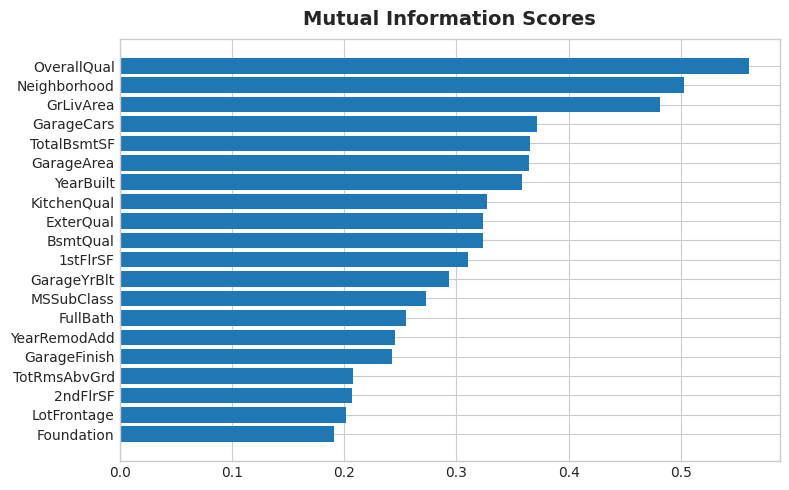

In [27]:
# 計算MI

mi_scores = make_mi_scores(im_X, y)

print('top 20:')
print(mi_scores.head(20))
print('bottom 20:')
print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
#plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

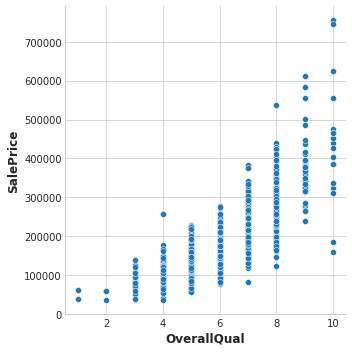

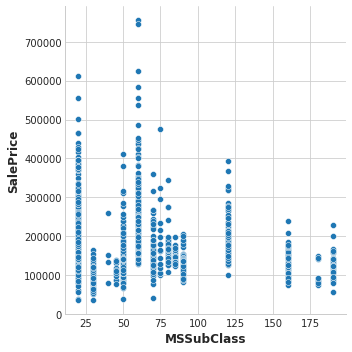

In [28]:
sns.relplot(x="OverallQual", y="SalePrice", data=train_df);
sns.relplot(x="MSSubClass", y="SalePrice", data=train_df);


In [29]:
#good_cols = ['OverallQual','Neighborhood','GrLivArea','GarageCars','TotalBsmtSF','GarageArea','YearBuilt',
             #'KitchenQual','ExterQual','BsmtQual','1stFlrSF','GarageYrBlt','MSSubClass']
good_cols = [col for col in im_X if mi_scores[col] > 0.01]
good_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal',
 'MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

In [30]:
good_X = im_X[good_cols]
good_X.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,150.0,...,Gd,Gd,Attchd,RFn,TA,TA,Y,MnPrv,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,284.0,...,TA,TA,Attchd,RFn,TA,TA,Y,MnPrv,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,434.0,...,Gd,TA,Attchd,RFn,TA,TA,Y,MnPrv,WD,Normal
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,540.0,...,Gd,Gd,Detchd,Unf,TA,TA,Y,MnPrv,WD,Abnorml
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,490.0,...,Gd,TA,Attchd,RFn,TA,TA,Y,MnPrv,WD,Normal


In [31]:
good_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   float64
 3   OverallQual    1460 non-null   float64
 4   OverallCond    1460 non-null   float64
 5   YearBuilt      1460 non-null   float64
 6   YearRemodAdd   1460 non-null   float64
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   float64
 9   BsmtUnfSF      1460 non-null   float64
 10  TotalBsmtSF    1460 non-null   float64
 11  1stFlrSF       1460 non-null   float64
 12  2ndFlrSF       1460 non-null   float64
 13  GrLivArea      1460 non-null   float64
 14  BsmtFullBath   1460 non-null   float64
 15  BsmtHalfBath   1460 non-null   float64
 16  FullBath       1460 non-null   float64
 17  HalfBath       1460 non-null   float64
 18  BedroomA

In [32]:
#處理categorical columns
# All categorical columns
object_cols = [col for col in good_X.columns if good_X[col].dtype == "object"]

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: good_X[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('CentralAir', 2),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('MasVnrType', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('KitchenQual', 4),
 ('Fence', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9)]

全部用one-hot就好

In [33]:
onehot_object_cols = [col for col in object_cols if good_X[col].nunique() < 10]

from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_X = pd.DataFrame(OH_encoder.fit_transform(good_X[onehot_object_cols]))

# One-hot encoding removed index; put it back
OH_X.index = good_X.index

# Remove "all" categorical columns 
num_X = good_X.drop(onehot_object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_X], axis=1)

OH_X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,147,148,149,150,151,152,153,154,155,156
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,150.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,284.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,434.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,540.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,490.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
good_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   float64
 3   OverallQual    1460 non-null   float64
 4   OverallCond    1460 non-null   float64
 5   YearBuilt      1460 non-null   float64
 6   YearRemodAdd   1460 non-null   float64
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   float64
 9   BsmtUnfSF      1460 non-null   float64
 10  TotalBsmtSF    1460 non-null   float64
 11  1stFlrSF       1460 non-null   float64
 12  2ndFlrSF       1460 non-null   float64
 13  GrLivArea      1460 non-null   float64
 14  BsmtFullBath   1460 non-null   float64
 15  BsmtHalfBath   1460 non-null   float64
 16  FullBath       1460 non-null   float64
 17  HalfBath       1460 non-null   float64
 18  BedroomA

In [35]:
#試看看減少feature有沒有比較好
'''from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
def get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y):
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

train_X, val_X, train_y, val_y = train_test_split(OH_X, y, train_size=0.8, test_size=0.2, random_state=0)

for n_estimators in [100, 200, 300, 400, 500, 1000]:
    for learning_rate in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
        my_mae = get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y)
        print("n_estimators: %d  learning_rate: %d \t\t Mean Absolute Error:  %d" %(n_estimators, learning_rate*100, my_mae))'''

'from sklearn.metrics import mean_absolute_error\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.ensemble import RandomForestRegressor\n\nfrom xgboost import XGBRegressor\nfrom sklearn.metrics import mean_absolute_error\ndef get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y):\n    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)\n    model.fit(train_X, train_y)\n    preds_val = model.predict(val_X)\n    mae = mean_absolute_error(val_y, preds_val)\n    return(mae)\n\ntrain_X, val_X, train_y, val_y = train_test_split(OH_X, y, train_size=0.8, test_size=0.2, random_state=0)\n\nfor n_estimators in [100, 200, 300, 400, 500, 1000]:\n    for learning_rate in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:\n        my_mae = get_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y)\n        print("n_estimators: %d  learning_rate: %d \t\t Mean Absolute Error:  %d" %(n_estimators, learning_rate*100, my_mae))'

n_estimators: 1000 learning_rate: 2 Mean Absolute Error: 16410 is the best <br>
0.1的：n_estimators: 500  learning_rate: 9 		 Mean Absolute Error:  16647 沒有比全部的好  <br>
0.05的：n_estimators: 300  learning_rate: 9 		 Mean Absolute Error:  16516 沒有比全部的好 <br>
0.01的：n_estimators: 500  learning_rate: 5 		 Mean Absolute Error:  16217 讚讚

# 處理要跑的train and test data

In [36]:
good_X = train_df[good_cols]
good_t = test_df[good_cols]

In [37]:
# missing values

numerical_cols = [col for col in good_t.columns if good_t[col].dtype != "object"]
object_cols = [col for col in good_t.columns if good_t[col].dtype == "object"]
# Fill in the lines below: imputation
num_imputer = SimpleImputer(strategy='median',missing_values=np.nan)
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #也不一定，要看那欄多半為什麼缺少，但先用most試看看

imputed_X_num = pd.DataFrame(num_imputer.fit_transform(good_X[numerical_cols]))
imputed_X_cat = pd.DataFrame(cat_imputer.fit_transform(good_X[object_cols]))

imputed_t_num = pd.DataFrame(num_imputer.transform(good_t[numerical_cols]))
imputed_t_cat = pd.DataFrame(cat_imputer.transform(good_t[object_cols]))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_num.columns = good_X[numerical_cols].columns
imputed_X_cat.columns = good_X[object_cols].columns
imputed_t_num.columns = good_t[numerical_cols].columns
imputed_t_cat.columns = good_t[object_cols].columns

im_X = pd.concat([imputed_X_num, imputed_X_cat], axis=1)
im_t = pd.concat([imputed_t_num, imputed_t_cat], axis=1)


In [38]:
im_t.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,270.0,...,TA,Gd,Attchd,Unf,TA,TA,Y,MnPrv,WD,Normal
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,406.0,...,Gd,Gd,Attchd,Unf,TA,TA,Y,MnPrv,WD,Normal
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,137.0,...,TA,TA,Attchd,Fin,TA,TA,Y,MnPrv,WD,Normal
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,324.0,...,Gd,Gd,Attchd,Fin,TA,TA,Y,MnPrv,WD,Normal
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,1017.0,...,Gd,Gd,Attchd,RFn,TA,TA,Y,MnPrv,WD,Normal


In [39]:
#處理categorical columns
onehot_object_cols = [col for col in object_cols if im_X[col].nunique() < 10]
ordinal_object_cols = [col for col in object_cols if im_X[col].nunique() >= 10]
onehot_object_cols_t = [col for col in object_cols if im_t[col].nunique() < 10]
ordinal_object_cols_t = [col for col in object_cols if im_t[col].nunique() >= 10]
print(onehot_object_cols)
print(ordinal_object_cols)
print(onehot_object_cols_t)
print(ordinal_object_cols_t)

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
['Neighborhood', 'Exterior1st', 'Exterior2nd']
['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']
['Neighborhood', 'Exterior1st', 'Exterior2nd']


catagoric 都一樣不用分

In [40]:
onehot_object_cols = [col for col in object_cols if im_X[col].nunique() < 10]
ordinal_object_cols = [col for col in object_cols if im_X[col].nunique() >= 10]

ordinal_encoder = OrdinalEncoder()
im_X[ordinal_object_cols] = ordinal_encoder.fit_transform(im_X[ordinal_object_cols])
im_t[ordinal_object_cols] = ordinal_encoder.transform(im_t[ordinal_object_cols])

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_X = pd.DataFrame(OH_encoder.fit_transform(im_X[onehot_object_cols]))
OH_t = pd.DataFrame(OH_encoder.transform(im_t[onehot_object_cols]))

# One-hot encoding removed index; put it back
OH_X.index = im_X.index
OH_t.index = im_t.index

# Remove "all" categorical columns 
num_X = im_X.drop(onehot_object_cols, axis=1)
num_t = im_t.drop(onehot_object_cols, axis=1)


# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_X], axis=1)
OH_t = pd.concat([num_t, OH_t], axis=1)

OH_t.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,147,148,149,150,151,152,153,154,155,156
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,270.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,406.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,137.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,324.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,1017.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
OH_X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,147,148,149,150,151,152,153,154,155,156
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,150.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,284.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,434.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,540.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,490.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
for i in numerical_cols:
    print(i, max(OH_t[i]))

MSSubClass 190.0
LotFrontage 200.0
LotArea 56600.0
OverallQual 10.0
OverallCond 9.0
YearBuilt 2010.0
YearRemodAdd 2010.0
MasVnrArea 1290.0
BsmtFinSF1 4010.0
BsmtUnfSF 2140.0
TotalBsmtSF 5095.0
1stFlrSF 5095.0
2ndFlrSF 1862.0
GrLivArea 5095.0
BsmtFullBath 3.0
BsmtHalfBath 2.0
FullBath 4.0
HalfBath 2.0
BedroomAbvGr 6.0
KitchenAbvGr 2.0
TotRmsAbvGrd 15.0
Fireplaces 4.0
GarageYrBlt 2207.0
GarageCars 5.0
GarageArea 1488.0
WoodDeckSF 1424.0
OpenPorchSF 742.0
EnclosedPorch 1012.0
ScreenPorch 576.0
MiscVal 17000.0


# start predict

In [43]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=500, learning_rate=0.05)
model.fit(OH_X, y)
preds = model.predict(OH_t)

In [44]:
# Save test predictions to file
output = pd.DataFrame({'Id': test_df.Id,
                       'SalePrice': preds})
output.to_csv('submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,124674.546875
1,1462,155897.046875
2,1463,185382.187500
3,1464,189889.625000
4,1465,191057.078125
